In [1]:
import sys, os 
from os.path import dirname
path = dirname(dirname(os.getcwd()))
sys.path.insert(0, path)
sys.path.insert(0, '/home/monte.flora/python_packages/scikit-explain')

import skexplain 
from skexplain.common.importance_utils import to_skexplain_importance
from src.io.io import load_data_and_model
from src.common.util import subsampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.io.display_names import feature_colors, display_feature_names, display_units
from skexplain.plot._kde_2d import PlotScatter
from scipy import stats

In [6]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

def plot(X, y, v1, v2, preds=None): 
    oranges = ListedColormap(
        ["xkcd:peach", "xkcd:orange", "xkcd:bright orange", "xkcd:rust brown"]
    )
    blues = ListedColormap(
        ["xkcd:periwinkle blue", "xkcd:lime", "xkcd:green"]
    )
    
    #["xkcd:periwinkle blue", "xkcd:clear blue", "xkcd:navy blue"]
    
    fig, axes = plt.subplots(dpi=300, ncols=2, sharex=True, sharey=True, figsize=(8,4))
    
    x1 = X[v1].values
    x2 = X[v2].values
    
    inds = np.random.permutation(len(X))

    X_sub = X.iloc[inds]
    X_sub.reset_index(inplace=True, drop=True)
    
    hb = axes[0].hexbin(x1, x2, 
                    bins='log', gridsize=50, mincnt=1, alpha=0.8)

    axes[1].hexbin(x1, x2[inds], 
               bins='log', gridsize=50, mincnt=1, alpha=0.8)

    
    
    #axes[1,0].hexbin(x1[inds], 
    #           x2, bins='log', gridsize=50, mincnt=1)

    #axes[1,1].hexbin(x1[inds], 
    #           x2[inds], bins='log', gridsize=50, mincnt=1)

    # Plot KDE Contours.
    inds = np.random.choice(len(X), size=20000, replace=False)
    
    x1_sub = x1[inds]
    x2_sub = x2[inds]
    y_sub = y[inds]
    
    cmap_set = [oranges,blues,]
    classes = np.unique(y)
    idx_sets = [np.where(y_sub == c) for c in classes]
    for idxs, cmap in zip(idx_sets, cmap_set):
        # Plot positive cases
        for ax in axes.flat: 
            cs = PlotScatter().plot_kde_contours(
                        ax,
                        dy=x2_sub[idxs],
                        dx=x1_sub[idxs],
                        target=y_sub[idxs],
                        cmap=cmap,
                    )
    
    v1_label = display_feature_names.get(v1,v1)
    v2_label = display_feature_names.get(v2,v2)
    
    v1_units = display_units.get(v1,'')
    v2_units = display_units.get(v2,'')
    
    titles = ['Original', 'Permuting'+'\n'+rf'{v1_label}', 'Permuting'+'\n'+rf'{v2_label}', 
         'Jointly Permuting' + '\n' + rf'{v1_label} & {v2_label}']

    for ax, title in zip(axes.flat, titles):
        ax.set_title(title)
        ax.tick_params(axis='both', labelsize=10)
        #ax.scatter(x1_sub, x2_sub, c=preds[inds], cmap='Purples')

    axes[0].set_xlabel(rf'{v1_label} ({v1_units})')
    axes[1].set_xlabel(rf'{v1_label} ({v1_units})')

    #axes[0,0].set_ylabel(rf'{v2_label} ({v2_units})')
    axes[0].set_ylabel(rf'{v2_label} ({v2_units})')


    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", "5%", pad="3%")

    cb = fig.colorbar(hb, cax=cax, label='log10(N)', orientation='vertical', pad=0.15)

    plt.tight_layout()
    
def plot_diff(X, y, v1, v2, subsample=True, model=None, add_kde=True):    
    oranges = ListedColormap(
        ["xkcd:peach", "xkcd:orange", "xkcd:bright orange", "xkcd:rust brown"]
    )
    blues = ListedColormap(
        ["xkcd:lime", "xkcd:kelly green", "xkcd:green"]
    )
    
    # define a function to create a 2D histogram
    def create_2d_hist(x, y, bins):
        hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
        return hist, xedges, yedges

    # create 2D histograms
    hist1, xedges, yedges = create_2d_hist(X[v1], X[v2], bins=50)

    xx,yy = np.meshgrid(xedges, yedges)
    
    # permute 'var3'
    v1_permuted = np.random.permutation(X[v1].values)

    preds = model.predict_proba(X)[:,1]
    X_permuted = X.copy()
    X_permuted[v1] = v1_permuted
    preds_permuted = model.predict_proba(X_permuted)[:,1]
    
    hist2, _, _ = create_2d_hist(v1_permuted, X[v2], bins=50)

    # compute the difference between the two histograms
    diff = hist2 - hist1
    
    v1_label = display_feature_names.get(v1,v1)
    v2_label = display_feature_names.get(v2,v2)
    
    v1_units = display_units.get(v1,'')
    v2_units = display_units.get(v2,'')
    
    f, axes = plt.subplots(dpi=300, figsize=(8,4), ncols=2, sharey=True)

    titles = ['Original\nConditional Distribution', f'Sample Size Change\nafter Permuting {v1_label}']
    labels = ['Sample Size', 'Sample Size Diff.']
    for i, (ax, z, cmap) in enumerate(zip(axes.flat, [hist1, diff], ['rocket', 'coolwarm'])):

        # plot the difference
        vmax = np.percentile(np.absolute(z), 90)
        vmin = -vmax
        z=np.ma.masked_where(z==0, z)
        if i ==1:
            c = ax.pcolormesh(xx, yy, z.T, cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            
            c = ax.pcolormesh(xx, yy, z.T, cmap=cmap, norm=LogNorm())
        plt.colorbar(c, ax=ax, orientation='horizontal', label=labels[i])
        ax.set_title(titles[i])
    
    # Plot KDE Contours.
    if add_kde:
        x1_sub = X[v1].values
        x2_sub = X[v2].values
        y_sub = y
        if subsample:
            inds = np.random.choice(len(X), size=20000, replace=False)
            x1_sub = x1_sub[inds]
            x2_sub = x2_sub[inds]
            y_sub = y_sub[inds]
        
            pred_sub = None
            if preds is not None:
                pred_sub = preds[inds]
                pred_pm_sub = preds_permuted[inds]
    
        cmap_set = [oranges,blues,]
        classes = np.unique(y)
        idx_sets = [np.where(y_sub == c) for c in classes]
        for idxs, cmap in zip(idx_sets, cmap_set):
            # Plot positive cases
            for ax in axes.flat: 
                cs = PlotScatter().plot_kde_contours(
                        ax,
                        dy=x2_sub[idxs],
                        dx=x1_sub[idxs],
                        target=y_sub[idxs],
                        cmap=cmap,
                    )
    
    #for ax, p, xs in zip(axes.flat, [pred_sub, pred_pm_sub], [x1_sub, v1_permuted[inds] ]):
    #    ax.scatter(xs, x2_sub, c=p, cmap='Purples', s=1, alpha=0.3)
    
    axes[0].set_xlabel(rf'{v1_label} ({v1_units})')
    axes[1].set_xlabel(rf'{v1_label} ({v1_units})')

    #axes[0,0].set_ylabel(rf'{v2_label} ({v2_units})')
    axes[0].set_ylabel(rf'{v2_label} ({v2_units})')
    
    plt.tight_layout()

In [8]:
dataset = 'lightning'
option = 'original'
BASE_PATH = '/work/mflora/explainability_work/'
DATA_BASE_PATH = os.path.join(BASE_PATH, 'datasets')
MODEL_BASE_PATH = os.path.join(BASE_PATH, 'models')
model, X, y = load_data_and_model(dataset, option, DATA_BASE_PATH, MODEL_BASE_PATH)

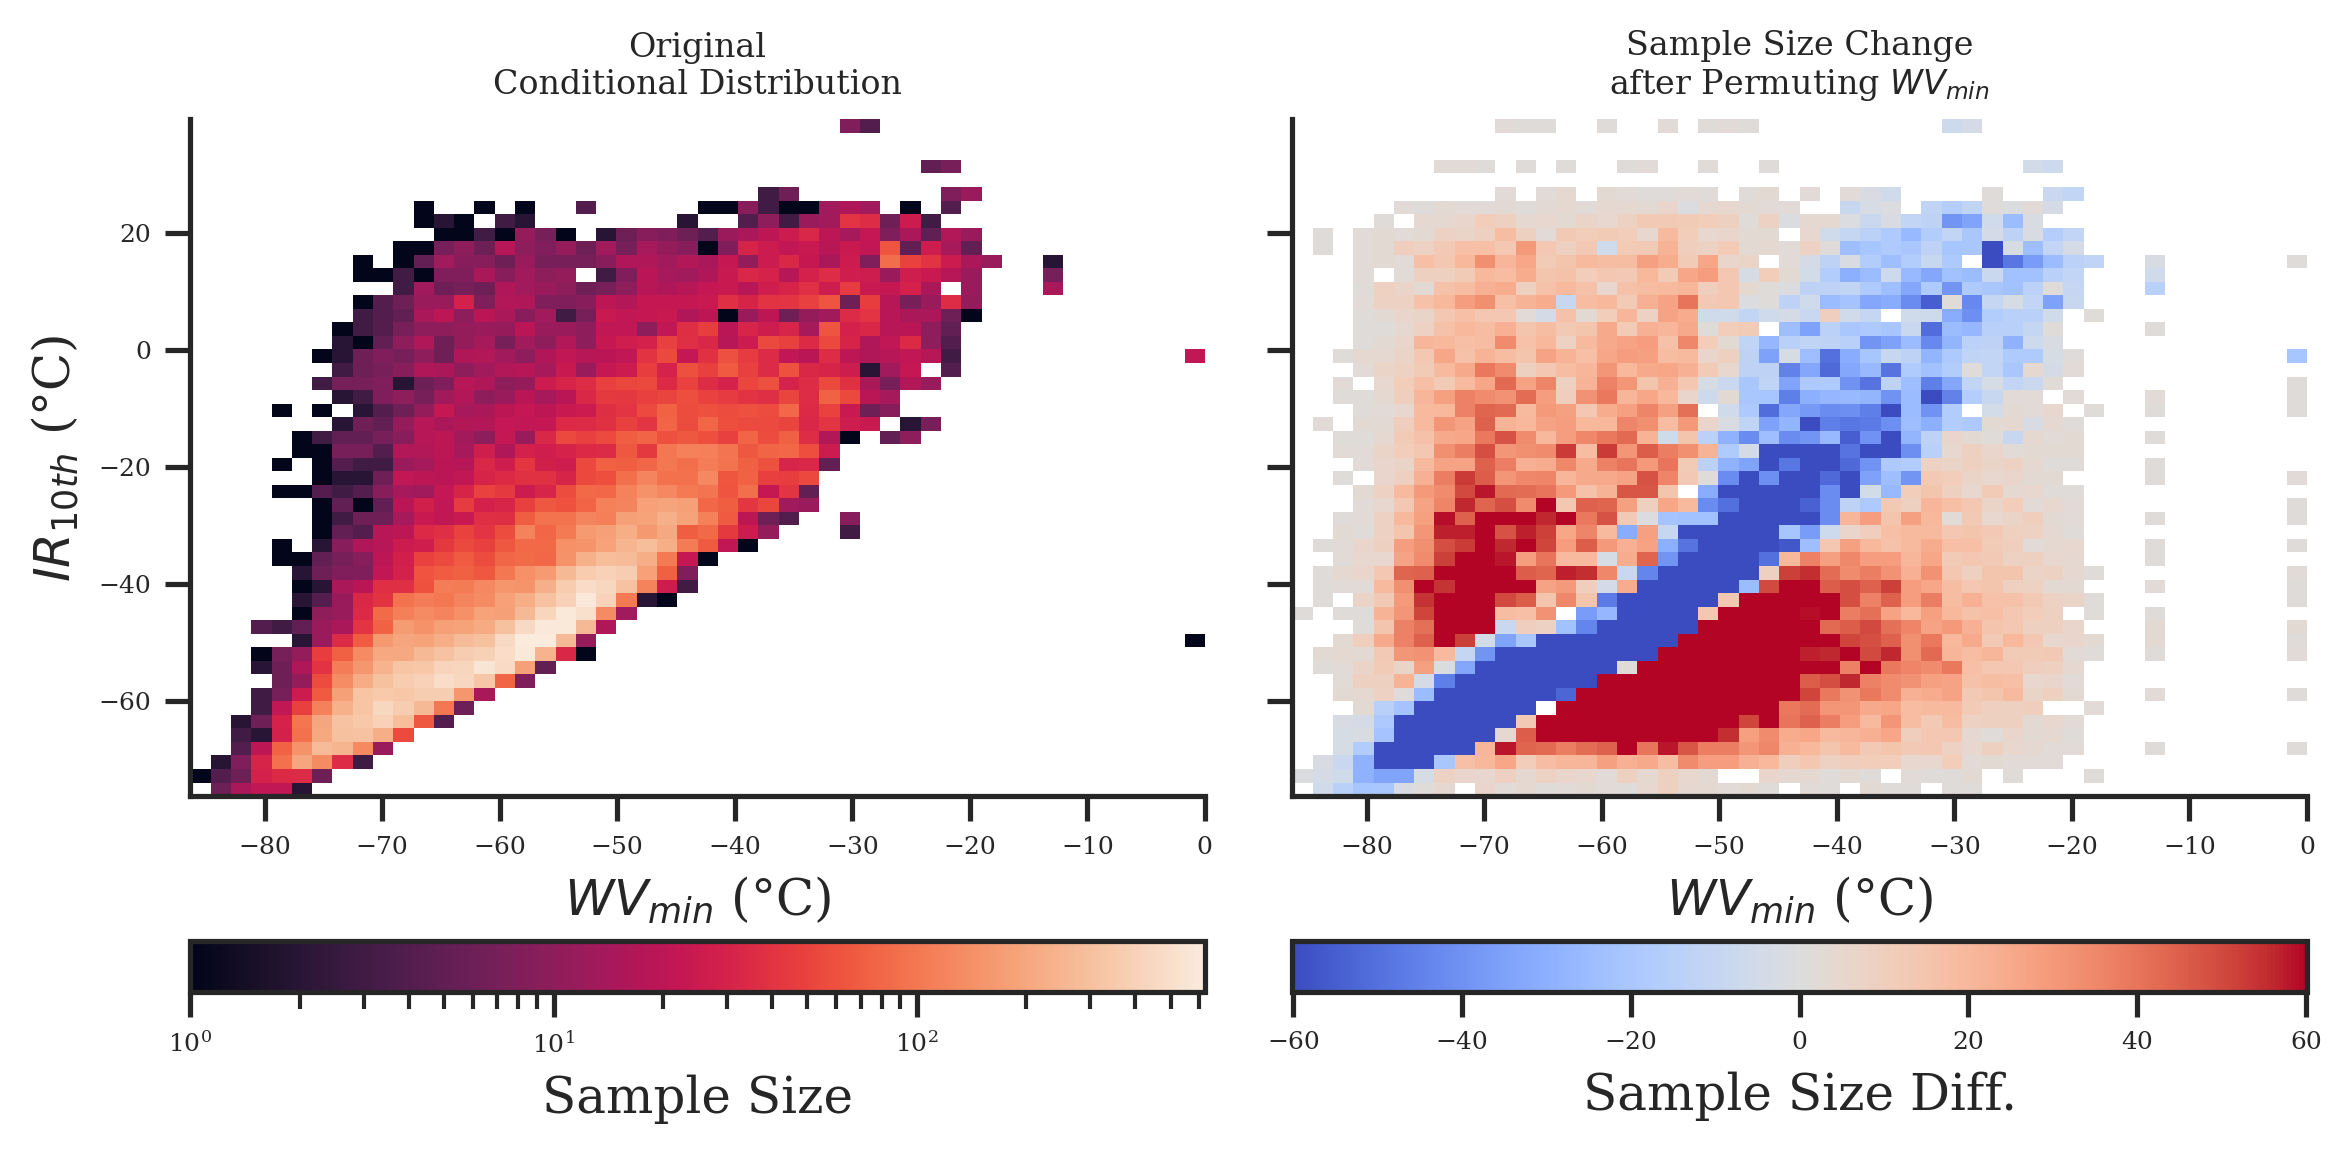

In [9]:
plot_diff(X, y, 'q000_wv', 'q010_ir', model=model[1], add_kde=False)

#plot_diff(X, y, 'w_down__time_min__ens_mean__spatial_mean', 
#          'ws_80__time_max__amp_ens_mean_spatial_perc_90', subsample=False )